# Import Library

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load Audio Data

In [4]:
PATH = "./AudioWAV/"

In [5]:
directory_list = os.listdir(PATH)

file_emotion = []
file_path = []

for file in directory_list:
  file_path.append(PATH + file)
  part = file.split('_')
  if part[2] == 'SAD':
    file_emotion.append('sad')
  elif part[2] == 'ANG':
    file_emotion.append('angry')
  elif part[2] == 'DIS':
    file_emotion.append('disgust')
  elif part[2] == 'FEA':
    file_emotion.append('fear')
  elif part[2] == 'HAP':
    file_emotion.append('happy')
  elif part[2] == 'NEU':
    file_emotion.append('neutral')
  else:
    file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns = ['Emotions'])

path_df = pd.DataFrame(file_path, columns = ['Path'])
crema_df = pd.concat([emotion_df, path_df], axis = 1)
crema_df.to_csv("crema_df.csv", index = False)
crema_df.head()

,Emotions,Path
0,angry,./AudioWAV/1001_DFA_ANG_XX.wav
1,disgust,./AudioWAV/1001_DFA_DIS_XX.wav
2,fear,./AudioWAV/1001_DFA_FEA_XX.wav
3,happy,./AudioWAV/1001_DFA_HAP_XX.wav
4,neutral,./AudioWAV/1001_DFA_NEU_XX.wav


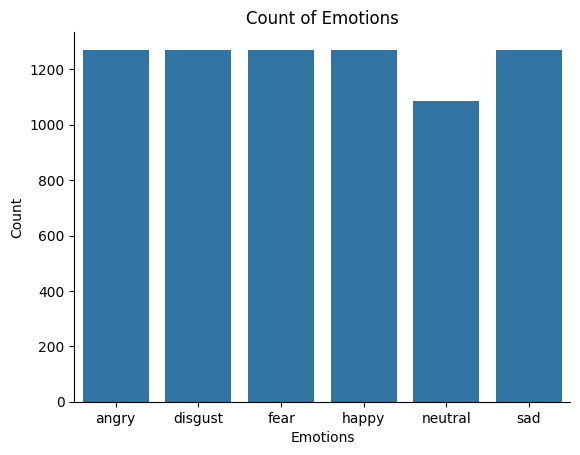

In [6]:
plt.title('Count of Emotions')
sns.countplot(x = crema_df.Emotions)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [7]:
def waveplot(data, sr, e):
  plt.figure(figsize = (10, 3))
  plt.title(f"{e} audio waveplot")
  librosa.display.waveshow(data, sr = sr)

def spectrogram(data, sr, e):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize = (12, 3))
  plt.title(f"{e} audio spectrogram")
  librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')

In [9]:
def noise(data):
  noise_amp = 0.035 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
  shift_range = int(np.random.uniform(low = -5, high = 5) * 1000)
  return np.roll(data, shift_range)

def pitch(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

path = np.array(crema_df.Path)[1]
data, sample_rate = librosa.load(path)

In [10]:
def extract_features(data):
    result = np.array([])

    mfcc = np.mean(librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 20).T, axis = 0)
    result = np.hstack((result, mfcc))

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration = 2.5, offset = 0.6)

    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    lowspeed_data = stretch(data, rate = 0.7)
    res3 = extract_features(lowspeed_data)
    result = np.vstack((result, res3))

    highspeed_data = stretch(data, rate = 1.25)
    res4 = extract_features(highspeed_data)
    result = np.vstack((result, res4))

    pitch_data = pitch(data, sample_rate, n_steps = 0.8)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    shift_data = shift(data)
    res6 = extract_features(shift_data)
    result = np.vstack((result, res6))

    return result

# Data Preparation

In [11]:
X, Y = [], []
for path, emotion in zip(crema_df.Path, crema_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [12]:
from concurrent.futures import ThreadPoolExecutor

def process_audio_file(path, emotion, X, Y):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)
    return (path, emotion)

if __name__ == "__main__":
    X, Y = [], []
    with ThreadPoolExecutor() as executor:
        futures = []
        for path, emotion in zip(crema_df.Path, crema_df.Emotions):
            future = executor.submit(process_audio_file, path, emotion, X, Y)
            futures.append(future)

        for future in futures:
            path, emotion = future.result()
#             print(path, " : ", emotion)

In [13]:
len(X), len(Y), crema_df.Path.shape

(44652, 44652, (7442,))

In [14]:
features = pd.DataFrame(X)
features['labels'] = Y
features.to_csv('features.csv', index = False)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-343.071167,123.145836,-18.152159,45.152039,3.317022,11.820989,-28.171919,3.126866,-8.081866,-5.423732,...,-3.102307,-1.432722,-17.611557,5.692105,-14.337687,-5.510109,-5.364413,-2.164049,-9.902680,happy
1,-224.606251,44.315649,1.771495,18.395505,11.793507,-2.195709,-11.924046,-5.842588,-3.900740,-6.151408,...,-2.322678,-4.342692,-10.996986,-1.740901,-7.492009,-7.738804,-2.063441,-3.688808,-6.306884,happy
2,-377.348511,117.542236,-16.562212,42.161098,5.616233,9.837592,-26.764275,2.167044,-7.692026,-5.582358,...,-3.025405,-1.386470,-16.307165,5.676712,-13.477029,-6.213637,-5.351098,-2.271983,-9.357913,happy
3,-370.535492,122.146843,-20.278606,43.588314,3.125002,11.503021,-30.090614,1.326732,-9.913952,-5.376186,...,-2.718957,-1.582056,-18.145390,6.376535,-14.375193,-5.678218,-5.658622,-2.409917,-10.757999,happy
4,-369.991577,120.898537,-18.934263,46.482712,1.650507,9.119425,-30.606415,8.506790,-11.671859,-2.848766,...,2.407784,-9.469318,-11.759858,4.560307,-17.916590,-3.649879,-7.469811,-2.707529,-12.072611,happy


In [74]:
X = features.iloc[: ,: -1].values
Y = features['labels'].values

In [75]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42, shuffle = True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 20), (33489, 6), (11163, 20), (11163, 6))

In [18]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 20), (33489, 6), (11163, 20), (11163, 6))

In [19]:
# only for CNN and CLSTM (LSTM with convolutional layer)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 20, 1), (33489, 6), (11163, 20, 1), (11163, 6))

# CNN

In [20]:
model = Sequential([
    Conv1D(64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu',input_shape = (x_train.shape[1], 1)),
    Conv1D(64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Dropout(0.25),
    MaxPooling1D(pool_size = 2, strides = 2, padding = 'same'),
    
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Dropout(0.25),
    MaxPooling1D(pool_size = 2, strides = 2, padding = 'same'),
    
    Conv1D(256, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    
    Flatten(),
    Dense(units = 6, activation = 'softmax'),
    
])

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 10, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 5, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,118 (945.77 KB)

 Trainable params: 242,118 (945.77 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
mdcp = ModelCheckpoint('best_model_weights.keras', monitor='val_accuracy', save_best_only=True)
# early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp, mdcp])

Epoch 1/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.3603 - loss: 1.5335 - val_accuracy: 0.4444 - val_loss: 1.3979 - learning_rate: 0.0010
Epoch 2/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.4370 - loss: 1.3893 - val_accuracy: 0.4478 - val_loss: 1.3664 - learning_rate: 0.0010
Epoch 3/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.4619 - loss: 1.3353 - val_accuracy: 0.4622 - val_loss: 1.3095 - learning_rate: 0.0010
Epoch 4/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.4906 - loss: 1.2700 - val_accuracy: 0.5014 - val_loss: 1.2389 - learning_rate: 0.0010
Epoch 5/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5104 - loss: 1.2291 - val_accuracy: 0.5313 - val_loss: 1.1879 - learning_rate: 0.0010
Epoch 6/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5344 - loss: 1.1653 - val_accuracy: 0.5527 - val_loss: 1.1357 - learning_rate: 0.0010
Epoch 7/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.56

349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8319 - loss: 0.5945
Testing Accuracy:  82.99739956855774 %


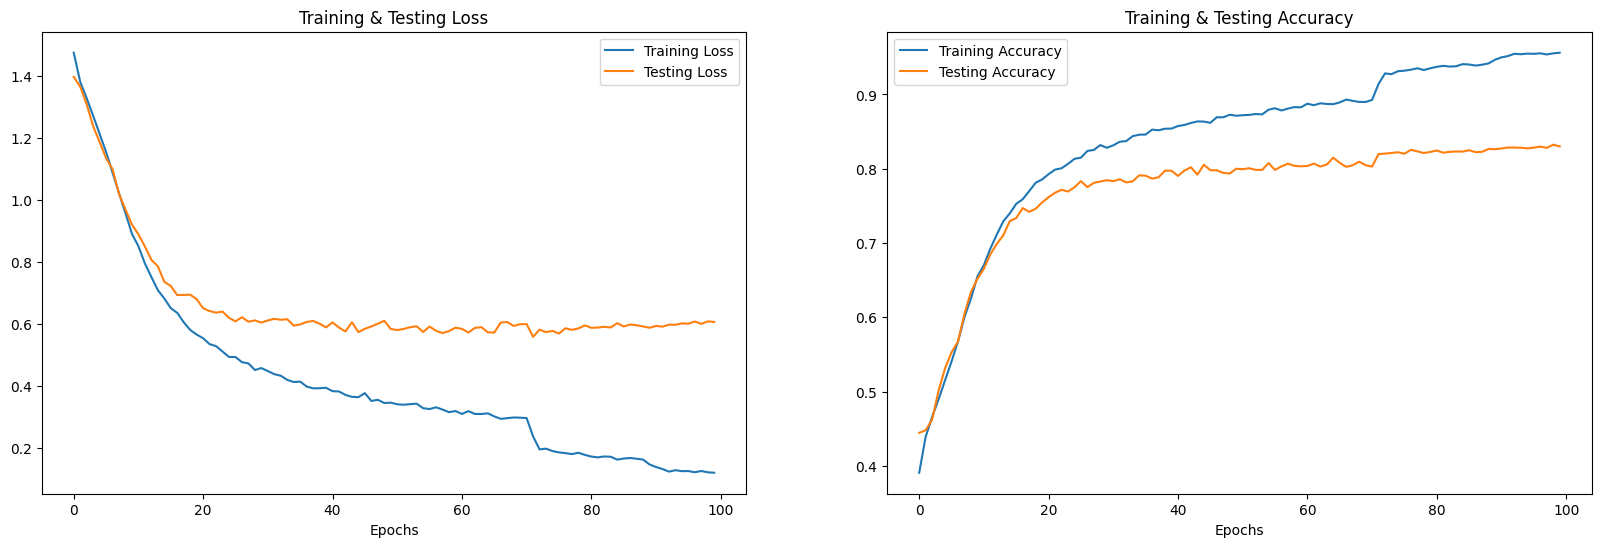

In [22]:
print("Testing Accuracy: " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [24]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


In [25]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,disgust,disgust
1,happy,happy
2,angry,angry
3,disgust,disgust
4,fear,fear
5,neutral,neutral
6,disgust,disgust
7,sad,sad
8,disgust,disgust
9,angry,angry


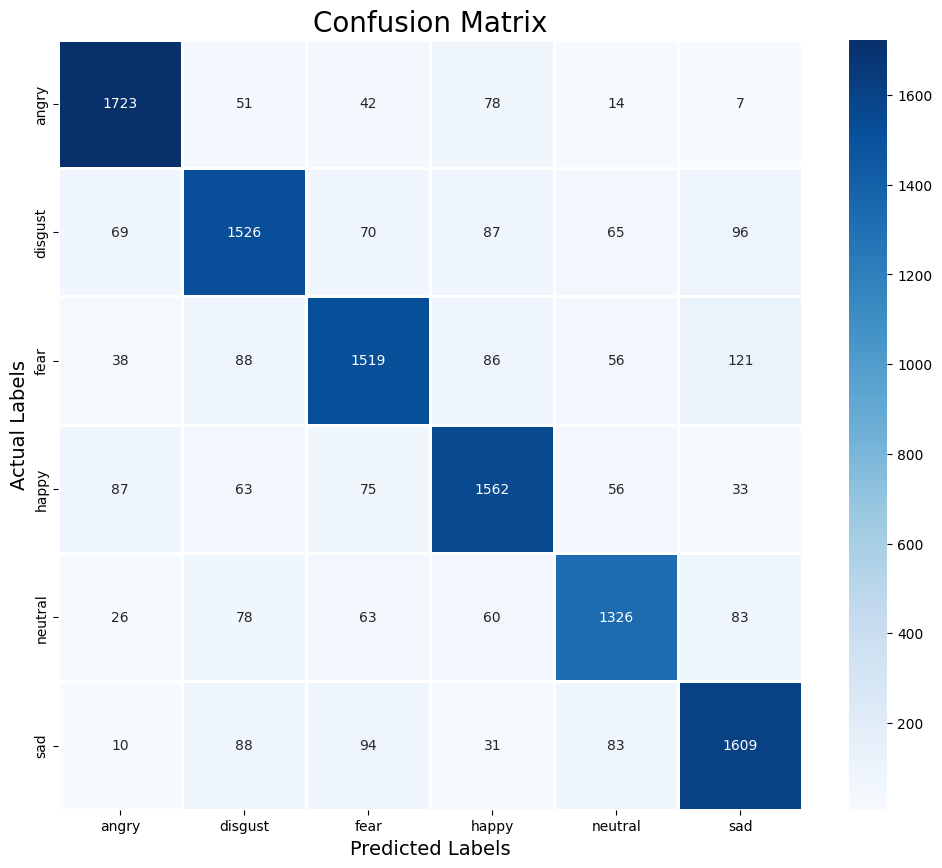

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [29]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_pred_labels, y_test_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

print(classification_report(y_test, y_pred))

Accuracy: 0.8299740213204336
Precision: 1.0
Recall: 1.0
F1-score: 1.0
              precision    recall  f1-score   support

       angry       0.88      0.90      0.89      1915
     disgust       0.81      0.80      0.80      1913
        fear       0.82      0.80      0.81      1908
       happy       0.82      0.83      0.83      1876
     neutral       0.83      0.81      0.82      1636
         sad       0.83      0.84      0.83      1915

    accuracy                           0.83     11163
   macro avg       0.83      0.83      0.83     11163
weighted avg       0.83      0.83      0.83     11163



# LSTM

In [76]:
X = features.iloc[: ,: -1].values
Y = features['labels'].values

In [77]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [78]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42, shuffle = True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 20), (33489, 6), (11163, 20), (11163, 6))

In [79]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 20), (33489, 6), (11163, 20), (11163, 6))

In [80]:
from keras.utils import to_categorical

y_test_encoded = to_categorical(y_test, num_classes=6)

from keras.layers import LSTM,BatchNormalization , GRU

model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
model01.add(LSTM(128,return_sequences=True))
model01.add(LSTM(128,return_sequences=True))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
model01.add(LSTM(128))
model01.add(Dense(6,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model01.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 20, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 20, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 20, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 20, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 20, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 20, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 856,838 (3.27 MB)

 Trainable params: 856,838 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
hist=model01.fit(x_train, y_train,
            epochs=20,
            validation_data=(x_test, y_test),batch_size=64,
            verbose=1)

Epoch 1/20
524/524 ━━━━━━━━━━━━━━━━━━━━ 126s 179ms/step - accuracy: 0.3247 - loss: 1.6015 - val_accuracy: 0.3747 - val_loss: 1.5278
Epoch 2/20
524/524 ━━━━━━━━━━━━━━━━━━━━ 90s 171ms/step - accuracy: 0.3665 - loss: 1.5220 - val_accuracy: 0.3635 - val_loss: 1.5086
Epoch 3/20
524/524 ━━━━━━━━━━━━━━━━━━━━ 92s 175ms/step - accuracy: 0.3861 - loss: 1.4866 - val_accuracy: 0.3979 - val_loss: 1.4577
Epoch 4/20
524/524 ━━━━━━━━━━━━━━━━━━━━ 105s 200ms/step - accuracy: 0.3954 - loss: 1.4615 - val_accuracy: 0.4043 - val_loss: 1.4416
Epoch 5/20
524/524 ━━━━━━━━━━━━━━━━━━━━ 105s 200ms/step - accuracy: 0.4062 - loss: 1.4428 - val_accuracy: 0.4129 - val_loss: 1.4248
Epoch 6/20
524/524 ━━━━━━━━━━━━━━━━━━━━ 89s 169ms/step - accuracy: 0.4125 - loss: 1.4309 - val_accuracy: 0.4204 - val_loss: 1.4173
Epoch 7/20
524/524 ━━━━━━━━━━━━━━━━━━━━ 91s 174ms/step - accuracy: 0.4234 - loss: 1.4137 - val_accuracy: 0.4209 - val_loss: 1.4022
Epoch 8/20
524/524 ━━━━━━━━━━━━━━━━━━━━ 97s 186ms/step - accuracy: 0.4232 - loss

349/349 ━━━━━━━━━━━━━━━━━━━━ 104s 297ms/step - accuracy: 0.5307 - loss: 1.1825
Accuracy of our model on test data :  53.148794174194336 %


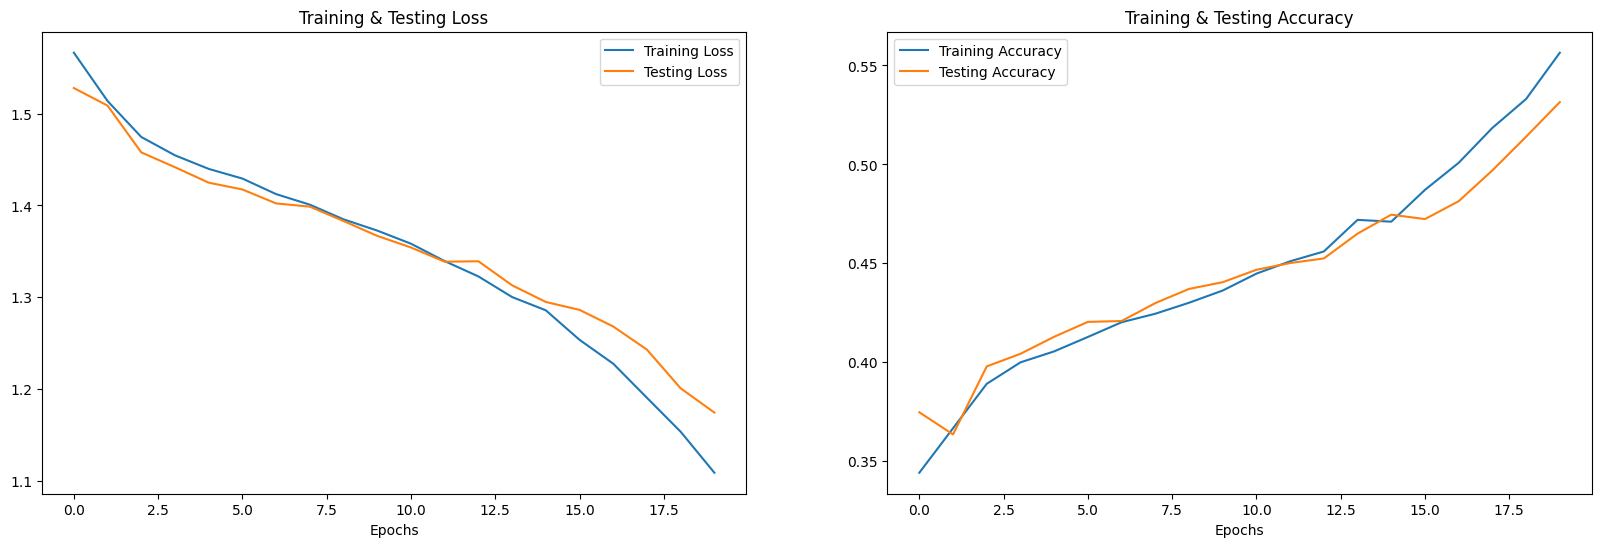

In [83]:
print("Accuracy of our model on test data : " , model01.evaluate(x_test,y_test)[1]*100 , "%")
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# CLSTM

In [98]:
model000 = Sequential()
model000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

          
model000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))
          
model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))
model000.add(LSTM(128))
model000.add(Dropout(0.3))

model000.add(Dense(128, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(64, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(32, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(6, activation='softmax'))



model000.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 20, 1024)       │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 10, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 10, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 10, 512)        │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 5, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 5, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 5, 256)         │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,778,214 (14.41 MB)

 Trainable params: 3,774,630 (14.40 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [99]:
# Data preparation for training CLSTM 

X = features.iloc[: ,: -1].values
Y = features['labels'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42, shuffle = True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# only for CNN and CLSTM (LSTM with convolutional layer)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 20, 1), (33489, 6), (11163, 20, 1), (11163, 6))

In [100]:
model000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [101]:
hist1=model000.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_test, y_test))

Epoch 1/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 195s 314ms/step - accuracy: 0.3349 - loss: 1.5768 - val_accuracy: 0.4108 - val_loss: 1.4519
Epoch 2/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 193s 296ms/step - accuracy: 0.4405 - loss: 1.3904 - val_accuracy: 0.4807 - val_loss: 1.3074
Epoch 3/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 222s 335ms/step - accuracy: 0.4756 - loss: 1.3184 - val_accuracy: 0.5039 - val_loss: 1.2452
Epoch 4/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 228s 383ms/step - accuracy: 0.5011 - loss: 1.2630 - val_accuracy: 0.5358 - val_loss: 1.1880
Epoch 5/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 214s 406ms/step - accuracy: 0.5280 - loss: 1.1943 - val_accuracy: 0.5645 - val_loss: 1.1290
Epoch 6/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 258s 397ms/step - accuracy: 0.5646 - loss: 1.1197 - val_accuracy: 0.5820 - val_loss: 1.0846
Epoch 7/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 254s 382ms/step - accuracy: 0.5845 - loss: 1.0685 - val_accuracy: 0.6035 - val_loss: 1.0252
Epoch 8/40
524/524 ━━━━━━━━━━━━━━━━━━━━ 226s 422ms/step - accuracy: 0.6044 -

349/349 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.8254 - loss: 0.5052
Accuracy of our model on test data :  82.02992081642151 %


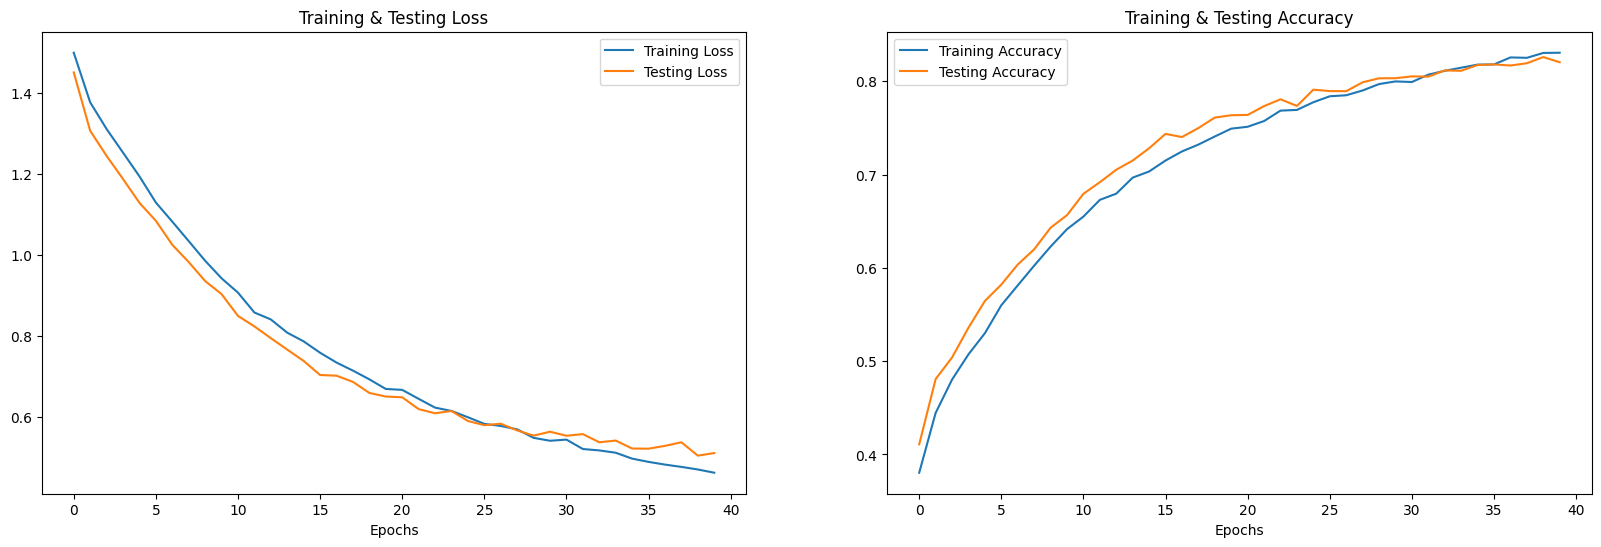

In [103]:
print("Accuracy of our model on test data : " , model000.evaluate(x_test,y_test)[1]*100 , "%")
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']
test_acc = hist1.history['val_accuracy']
test_loss = hist1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [105]:
# predicting on test data.
pred_test00 = model000.predict(x_test)
y_pred00 = encoder.inverse_transform(pred_test)
y_test00 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred00.flatten()
df0['Actual Labels'] = y_test00.flatten()

df0.head(10)

349/349 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step


,Predicted Labels,Actual Labels
0,disgust,disgust
1,happy,happy
2,angry,angry
3,disgust,disgust
4,fear,fear
5,neutral,neutral
6,disgust,disgust
7,sad,sad
8,disgust,disgust
9,angry,angry
